# <center> Shopee Comprehensive EDA - All you Need to Know! </center>

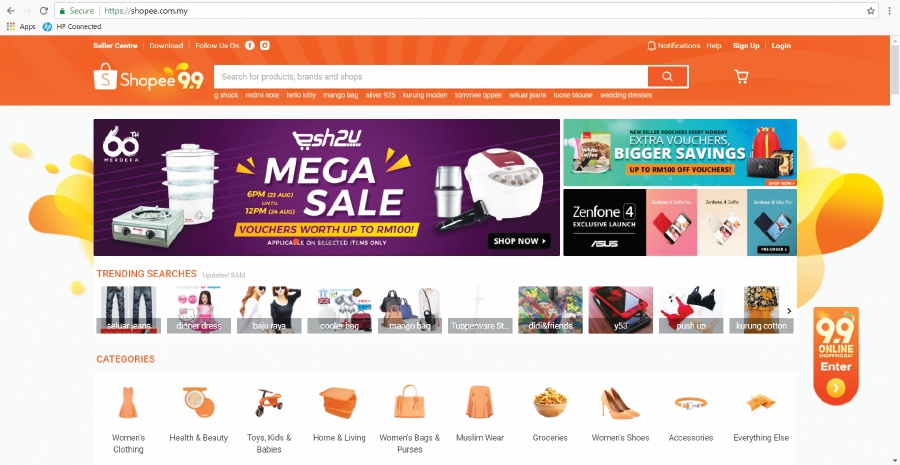

### <center> The goal of this competition is to detect identical product postings that merchants post on **Shopee**, a leading e-commerce platform in Southeast Asia and Taiwan. To do so, we have access to both the products' images and some addition data such as the title of the products' postings. </center>

 Shopee: EDA+RAPIDS preprocessing
Updated 2h ago
6 comments · Shopee - Price Match Guarantee
18
 Bronze


In [ ]:
#imports

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from PIL import Image
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
import os

In [ ]:
!ls /kaggle/input/shopee-product-matching

So all that we're provided with are the training and testing images sets, along with their corresponding csv files with probably more details on each image.

In [ ]:
!ls /kaggle/input/shopee-product-matching/train_images | wc -l
!ls /kaggle/input/shopee-product-matching/train_images | head -10

We can see that we are provided with a total of **32,412** training images, named using some kind of image ID.

In [ ]:
!ls /kaggle/input/shopee-product-matching/test_images | wc -l
!ls /kaggle/input/shopee-product-matching/test_images

The testing images set however only contains **3** images! Quoting the data desciption section of this competition:

> As this is a code competition, only the first few rows/images of the test set are published; the remainder are only available to your notebook when it is submitted. Expect to find roughly 70,000 images in the hidden test set. The few test rows and images that are provided are intended to illustrate the hidden test set format and folder structure.

In [ ]:
# Reading the CSV files
train_df = pd.read_csv('../input/shopee-product-matching/train.csv')
test_df = pd.read_csv('../input/shopee-product-matching/test.csv')
sample_df = pd.read_csv('../input/shopee-product-matching/sample_submission.csv')

In [ ]:
train_df

It seems like the *train.csv* files contains **34,250** rows, that is higher than the number of images in the training directory by around **2,000** images.

Also, we can see that each row contains 5 columns:
* `posting_id`: Which is the unique ID for each row representing an item posting on Shopee.
* `image`: Refering to the image ID that is located within the train images directory.
* `image_phash`: That is a hash of the image. **phash** in this case most probably refers to **perception hashing** which is one type of image hashing that uses a series of classical image processing steps, such as resizing and frequencies count, to construct the hash of an image. Essentially, the aim of a hasing algorithm is to assign unique hash values for different images, and identical hashes for identical images. However, no hashing algorithm is completely perfect, so whenevr we encounter 2 images having the same hash, this means that *most probably* those are the same images.
* `title`: That is the title of the posting on Shopee, which logically should be describing the item itself that is present in the corresponding image.
* `label_group`: We'll have to further discover the data to know for sure what this field representes, but it seems like it is referring to rows that have the same product. Meaning, that 2 rows having the same *label_group* contain the same item. 

In [ ]:
train_df.info()

No null values, woohoo!

In [ ]:
for col in train_df.columns:
    print(f"{col}: {len(train_df[col].unique())}")

* It looks like `posting_id` is the only column with unique values for every row in the dataset.
* The lower number of unique `image` values indicates that several postings share the same image.
* The lower number of unique `image_phash` values indicates that a great amount of images share the same Phash, meaning that a great amount of images are duplicates (or at least very close).
* The lower number of unique `title` values indicates that several postings share the same exact product title.
* The number of `label_group` seems to indicate the number of **unique** products in the datasets. Meaning, this is the value that will link rows together as refering to the same product, albeit having different postings, images and titles.

## Visualizing Some of the Training Data Images

In [ ]:
fig = plt.figure(figsize=(18,20))
plt.subplots_adjust(wspace=0.8)
columns = 6
rows = 8
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns,i)
    img = Image.open(os.path.join("/kaggle/input/shopee-product-matching/train_images", train_df.iloc[i,1]))
    plt.imshow(img)
    if len(train_df.iloc[i,3]) > 30:
        title = train_df.iloc[i,3][:30] + "..."
    else:
        title = train_df.iloc[i,3] + "."
    ax.set_title(title, fontsize=8)
    ax.axis('off')

In [ ]:
sizes = []
ratios = []
for img_name in tqdm(train_df['image']):
    img = Image.open(os.path.join("/kaggle/input/shopee-product-matching/train_images", img_name))
    sizes.append(img.size)
    ratios.append(img.size[0] / img.size[1])

In [ ]:
Counter(ratios).most_common(10)

It looks like the vast majority of the images, with a very low number of outliers, have a ratio of 1, meaning that the images are squares.

In [ ]:
Counter(sizes).most_common(20)

In [ ]:
imgs_dim = []
dim_count = []
for k, v in Counter(sizes).most_common(20):
    imgs_dim.append(str(k[0]))
    dim_count.append(v)
fig = px.bar(x=imgs_dim, y=dim_count,
             color=dim_count,
             color_continuous_scale=px.colors.sequential.Blues,
             title="<b>Square Image Dimension Distribution</b>",
             text=[str(y/train_df.shape[0] * 100)[:str(y/train_df.shape[0] * 100).find(".") + 2] + "%" for y in dim_count]
            )
fig.update_traces(hovertemplate = "<b>%{x}*%{x}</b><br>Count: %{y}")
fig.update_layout(showlegend=False,
                  title_font_size=18,
                  yaxis={"title": "Number of Occurences", "gridcolor": "rgb(235,235,235)",
                         "zeroline":True, "zerolinecolor":"lightgrey"},
                  xaxis={"title":"Square Image Dimension"},
                  plot_bgcolor="#fff",
                  coloraxis={"showscale":False}
                 )

fig.show()

# This notebook is under development 🚧

---

## Please upvote if you found it useful 😊